# Healthcare Data Analysis & Modeling

## Initializing

In [1]:
#!pip3 install seaborn
#!pip3 install missingno
#!pip3 install scikit-learn 
#!pip3 install numba==0.53.1
#!pip3 install shap
#!pip3 install imbalanced-learn

In [2]:
import numpy as np 
import pandas as pd
import math 
import re
import imblearn
import shap
import seaborn as sns
import missingno as msno
import matplotlib.patches as mpatches
import matplotlib.colors as colors

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display
from imblearn.over_sampling import SMOTE
from datetime import datetime
from shap import TreeExplainer
from dateutil.relativedelta import relativedelta

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, accuracy_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import make_pipeline


In [3]:
#colormap
holmuskblue3 = '#526ca9'
holmuskbg = '#eef0f7'

holmuskpalette_light = ['#dde2ee', '#bac5de', '#98a8cd', '#758bbd', '#536eac', '#4b639b']
holmuskpalette_diverse = ['#bac5de', '#758bbd', '#3a4d78', '#212c45']

In [4]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

### Helper functions

In [5]:
#sets monetary values to plot axis 
def monetary_ticks(value, tick_number):
    return f'{value/1000:,.0f}'+'k'

## View the Data

Dataset consists of 4 separate .csv files that we join together later.

In [6]:
bill_amount_df = pd.read_csv('raw_data/bill_amount.csv')
bill_id_df = pd.read_csv('raw_data/bill_id.csv')
clinical_data_df = pd.read_csv('raw_data/clinical_data.csv')
demographics_df = pd.read_csv('raw_data/demographics.csv')

In [7]:
display(bill_amount_df.head())
display(bill_id_df.head())
display(clinical_data_df.head())
display(demographics_df.head())

,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351
3,3818426276,755.965425
4,9833541918,897.347816


,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01


,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0


,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


In [8]:
clinical_data_df.isnull().sum()

id                      0
date_of_admission       0
date_of_discharge       0
medical_history_1       0
medical_history_2     233
medical_history_3       0
medical_history_4       0
medical_history_5     304
medical_history_6       0
medical_history_7       0
preop_medication_1      0
preop_medication_2      0
preop_medication_3      0
preop_medication_4      0
preop_medication_5      0
preop_medication_6      0
symptom_1               0
symptom_2               0
symptom_3               0
symptom_4               0
symptom_5               0
lab_result_1            0
lab_result_2            0
lab_result_3            0
weight                  0
height                  0
dtype: int64

## Preparing the data
Changing data types and recoding variables. 

In [9]:
bill_id_df = bill_id_df.astype({'patient_id':str, 'date_of_admission':'datetime64'})
clinical_data_df = clinical_data_df.astype({'date_of_admission':'datetime64', 'date_of_discharge':'datetime64'})

In [10]:
clinical_data_df.replace('No', 0, inplace = True)
clinical_data_df.replace('Yes', 1, inplace = True)
clinical_data_df[clinical_data_df.columns[3:26]] = clinical_data_df[clinical_data_df.columns[3:26]].astype(float)
clinical_data_df = clinical_data_df.rename(columns={'id': 'patient_id'})

In [11]:
demographics_df= demographics_df.astype({'patient_id':str, 'gender':str, 'race':str, 'resident_status':str, 'date_of_birth':'datetime64'})
demographics_df.gender.replace({'Female': 'f', 'Male':'m'}, inplace = True)
demographics_df.race.replace({'chinese': 'Chinese', 'India':'Indian', 'Others':'Other'}, inplace = True)

## Joining the datasets 
We join the 4 data files into 1 based on patient_id. As a result, we get data on admission level.  

In [12]:
# join bill_amount_df and bill_id_df on bill_id: 
financials_df = pd.merge(bill_id_df, bill_amount_df, on='bill_id', how = 'left')

#join clinical_data_df on financial_df on patient_id
medical_financials_df = pd.merge(financials_df, clinical_data_df, on=['patient_id', 'date_of_admission'])

#join demographics_df to medical_financials_df on patient_id
df = pd.merge(demographics_df, medical_financials_df, on='patient_id')

In [13]:
#grouping to admission level data
f = {'gender':'first',
     'race':'first',
     'resident_status':'first',
     'date_of_birth':'first',
     'amount' : 'sum', 
     'date_of_discharge': 'first',
     'medical_history_1': 'first', 
     'medical_history_2':'first', 
     'medical_history_3':'first', 
     'medical_history_4':'first', 
     'medical_history_5': 'first', 
     'medical_history_6':'first', 
     'medical_history_7':'first', 
     'preop_medication_1':'first', 
     'preop_medication_2': 'first', 
     'preop_medication_3': 'first', 
     'preop_medication_4':'first', 
     'preop_medication_5':'first', 
     'preop_medication_6':'first', 
     'symptom_1':'first', 
     'symptom_2':'first', 
     'symptom_3':'first', 
     'symptom_4':'first', 
     'symptom_5':'first', 
     'lab_result_1':'first', 
     'lab_result_2':'first', 
     'lab_result_3':'first', 
     'weight':'first',
     'height':'first'
    }

df = df.groupby(['patient_id', 'date_of_admission']).agg(f)
df = df.reset_index()
df.head()

,patient_id,date_of_admission,gender,race,resident_status,date_of_birth,amount,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,00225710a878eff524a1d13be817e8e2,2014-04-10,f,Chinese,Singaporean,1983-01-16,5190.566695,2014-04-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.4,27.9,96.0,66.9,155.0
1,0029d90eb654699c18001c17efb0f129,2012-11-07,f,Chinese,Singaporean,1943-10-14,22601.497872,2012-11-20,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,16.7,26.5,109.0,89.1,160.0
2,0040333abd68527ecb53e1db9073f52e,2013-01-19,m,Indian,Singaporean,1972-08-26,17447.181635,2013-01-31,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.8,25.2,96.0,79.5,172.0
3,00473b58e3dc8ae37b3cb34069705083,2014-02-10,f,Chinese,Singapore citizen,1976-07-23,15285.883220,2014-02-15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,14.9,28.7,122.0,81.1,160.0
4,0078662d1d983dde68ea057c42d5b5cf,2012-04-28,m,Malay,Foreigner,1942-10-19,73477.869010,2012-05-10,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,14.2,27.2,89.0,74.7,173.0


### Feature Engineering

In [14]:
#add columns for age in years on admission: 
days_in_year = 365.2425   
df['age_on_admission'] =((df.date_of_admission - df.date_of_birth).dt.days / days_in_year).astype(int)

#add column for length of stay in days: 
df['length_of_stay'] = (df.date_of_discharge - df.date_of_admission).dt.days

#add column for total number of admissions in 2011-2015
df['total_admissions'] = df.groupby('patient_id').patient_id.transform('count')

#creating BMI_value and BMI_class columns using Asia-Pacific body mass index
df['BMI_value'] = df.weight / (df.height/100)**2
df['BMI_class'] = None
df['BMI_class'].mask(df['BMI_value']<18.5, 'underweight', inplace=True)
df['BMI_class'].mask(df['BMI_value']>=18.5,'normal', inplace = True) 
df['BMI_class'].mask(df['BMI_value']>=23, 'overweight', inplace = True) 
df['BMI_class'].mask(df['BMI_value']>=25, 'obese', inplace = True) 

In [15]:
#arrange columns
df = df[['patient_id',
 'date_of_birth',
 'gender',
 'race',
 'resident_status',
 'weight',
 'height',
 'BMI_value',
 'BMI_class',
 'age_on_admission',
 'date_of_admission',
 'date_of_discharge',
 'length_of_stay',
 'total_admissions',
 'amount',
 'medical_history_1',
 'medical_history_2',
 'medical_history_3',
 'medical_history_4',
 'medical_history_5',
 'medical_history_6',
 'medical_history_7',
 'preop_medication_1',
 'preop_medication_2',
 'preop_medication_3',
 'preop_medication_4',
 'preop_medication_5',
 'preop_medication_6',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5',
 'lab_result_1',
 'lab_result_2',
 'lab_result_3'
]]

In [16]:
#describe continuous data, all patients
describe = df.select_dtypes(include=[np.float64]).describe()
describe

,weight,height,BMI_value,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3167.000000,3400.000000,3400.000000,3096.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,78.748441,165.084412,28.958874,21859.071130,0.169118,0.311336,0.136176,0.052059,0.063953,0.254706,0.254412,0.503824,0.591176,0.820882,0.523235,0.819706,0.744118,0.619706,0.662353,0.544706,0.726471,0.526765,14.469882,27.431529,99.489706
std,10.975076,6.973678,4.140674,10155.336753,0.374911,0.463113,0.343026,0.222178,0.244710,0.435760,0.435594,0.500059,0.491689,0.383507,0.499533,0.384489,0.436420,0.485530,0.472977,0.498071,0.445836,0.499357,1.747323,2.463844,15.254453
min,48.000000,151.000000,17.508651,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,52.000000
25%,71.200000,160.000000,26.156074,14793.370831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.200000,25.800000,88.000000
50%,78.900000,165.000000,28.943985,20180.020614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,27.400000,100.000000
75%,86.300000,170.000000,31.713345,26680.292435,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.800000,29.100000,110.000000
max,121.000000,186.000000,46.677349,98723.854994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.300000,35.100000,150.000000


In [17]:
#describe continuous data, men
df[df.gender == 'm'][describe.columns].describe()

,weight,height,BMI_value,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3
count,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1586.000000,1698.000000,1698.000000,1548.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000
mean,82.950530,170.040636,28.755061,22446.032462,0.163133,0.306431,0.138398,0.047703,0.056202,0.273852,0.237338,0.500000,0.586572,0.826266,0.504711,0.808598,0.748528,0.623675,0.654299,0.560660,0.736160,0.533569,14.433039,27.421437,99.631920
std,10.170192,4.870279,3.857861,10295.352689,0.369596,0.461156,0.345419,0.213200,0.230385,0.446065,0.425577,0.500147,0.492593,0.378992,0.500125,0.393520,0.433987,0.484606,0.475736,0.496453,0.440843,0.499019,1.734851,2.468971,15.163244
min,56.000000,161.000000,18.724174,4027.726961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,20.200000,57.000000
25%,76.300000,166.000000,26.063155,15234.303392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.100000,25.700000,88.000000
50%,83.100000,170.000000,28.799351,21063.894017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.400000,27.400000,100.000000
75%,90.100000,173.000000,31.363417,27168.156055,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.700000,29.100000,110.000000
max,121.000000,186.000000,40.900487,98723.854994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.900000,35.100000,150.000000


In [18]:
#describe continuous data, women
df[df.gender == 'f'][describe.columns].describe()

,weight,height,BMI_value,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3
count,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1581.000000,1702.000000,1702.000000,1548.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000
mean,74.556228,160.139835,29.162208,21273.489261,0.175088,0.316256,0.133960,0.056404,0.071705,0.235605,0.271445,0.507638,0.595770,0.815511,0.541716,0.830787,0.739718,0.615746,0.670388,0.528790,0.716804,0.519976,14.506639,27.441598,99.347826
std,10.113911,4.952848,4.396498,9982.373541,0.380154,0.465161,0.340709,0.230768,0.258083,0.424501,0.444836,0.500089,0.490887,0.387996,0.498403,0.375050,0.438917,0.486561,0.470210,0.499317,0.450683,0.499748,1.759418,2.459403,15.348051
min,48.000000,151.000000,17.508651,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,52.000000
25%,67.800000,157.000000,26.265665,14458.248630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.300000,25.800000,88.000000
50%,74.700000,160.000000,29.132744,19521.562498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,27.450000,100.000000
75%,81.200000,164.000000,31.925973,26410.583656,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.800000,29.200000,110.000000
max,110.700000,174.000000,46.677349,88873.627994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.300000,35.000000,146.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          3400 non-null   object        
 1   date_of_birth       3400 non-null   datetime64[ns]
 2   gender              3400 non-null   object        
 3   race                3400 non-null   object        
 4   resident_status     3400 non-null   object        
 5   weight              3400 non-null   float64       
 6   height              3400 non-null   float64       
 7   BMI_value           3400 non-null   float64       
 8   BMI_class           3400 non-null   object        
 9   age_on_admission    3400 non-null   int64         
 10  date_of_admission   3400 non-null   datetime64[ns]
 11  date_of_discharge   3400 non-null   datetime64[ns]
 12  length_of_stay      3400 non-null   int64         
 13  total_admissions    3400 non-null   int64       

## Explanatory Data Analysis 

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


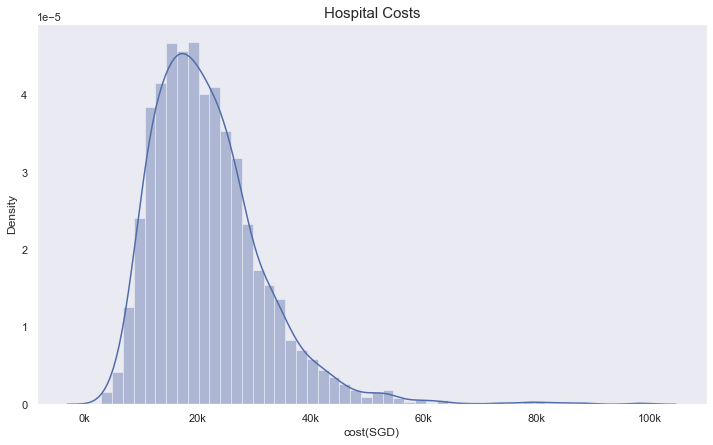

In [20]:
#Hospital costs
sns.set_theme()
plt.figure(figsize = (12,7))
ax = sns.distplot(x=df.amount, color = holmuskblue3)

ax.xaxis.set_major_formatter(FuncFormatter(monetary_ticks))
ax.set_xlabel('cost(SGD)')
ax.set_title('Hospital Costs', fontsize = 15)

ax.grid(False)

In [21]:
def plot_pie(data, column_name, title):
    d = pd.DataFrame(data[column_name].value_counts() / len(data[column_name]))
    d.reset_index(inplace = True)
    d.columns = ['perc', column_name]
    fig = plt.figure(figsize = (5,5))

    ax = fig.add_axes([10, 10, .8, .8], aspect=1)
    ax.pie(d[column_name], autopct = '%0.1f%%', labels = d.perc, colors=sns.color_palette(holmuskpalette_light))
    ax.set_title(title, pad = 20, fontsize = 15)

    plt.show()

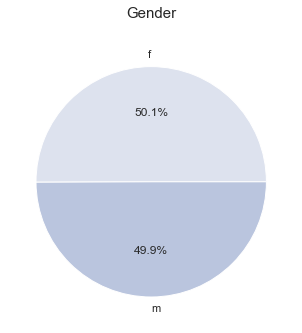

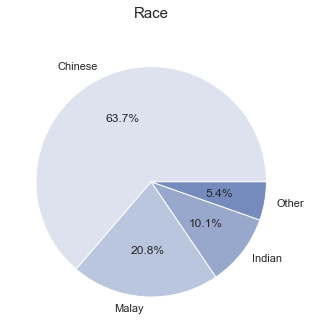

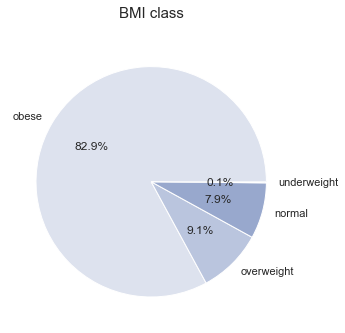

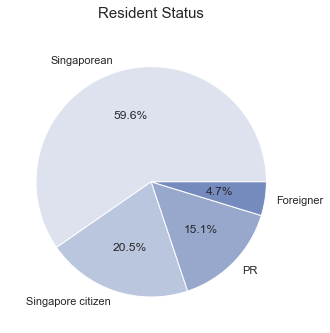

In [22]:
#gender
plot_pie(df, 'gender', 'Gender')
plot_pie(df, 'race', 'Race')
plot_pie(df, 'BMI_class', 'BMI class')
plot_pie(df, 'resident_status', 'Resident Status')

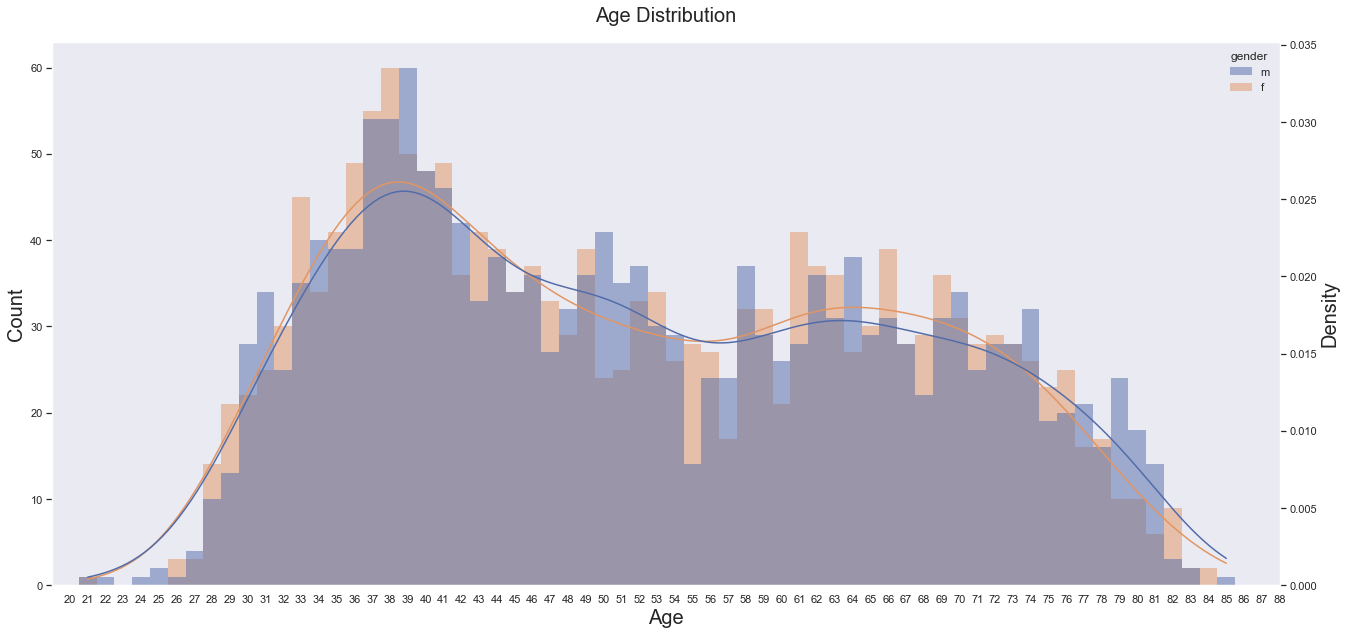

In [23]:
#age
sns.set_style({'axes.grid' : False})
holmuskpalette2 = [holmuskblue3, '#e29562']

fig, ax1 = plt.subplots(figsize = (22,10)) 
ax2 = ax1.twinx()

plt.rcParams['patch.linewidth'] = 0
sns.histplot(x = df.age_on_admission, bins = np.arange(90) - 0.5, ax = ax2, stat = 'density', alpha = 0.0) 
sns.histplot(x = df.age_on_admission, bins = np.arange(90) - 0.5, ax = ax1, stat = 'count', hue = df.gender, hue_order = ['m', 'f'], kde=True, palette = holmuskpalette2) 

ax1.set_xlabel('Age', fontsize = 20)
ax1.set_xticks(range(20,90,1))

ax1.set_ylabel('Count',  fontsize = 20)
ax2.set_ylabel('Density',  fontsize = 20)
ax2.set_title('Age Distribution', fontsize = 20, pad = 20)
plt.xlim([19, 88])

plt.show()


In [24]:
def plot_dist(df, column_name, title, bins):
    sns.set_theme()
    plt.figure(figsize = (12,7))

    ax = sns.distplot(x=df[column_name], color = holmuskblue3, bins = bins)
    ax.set_title(title, fontsize = 15)
    ax.grid(False)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


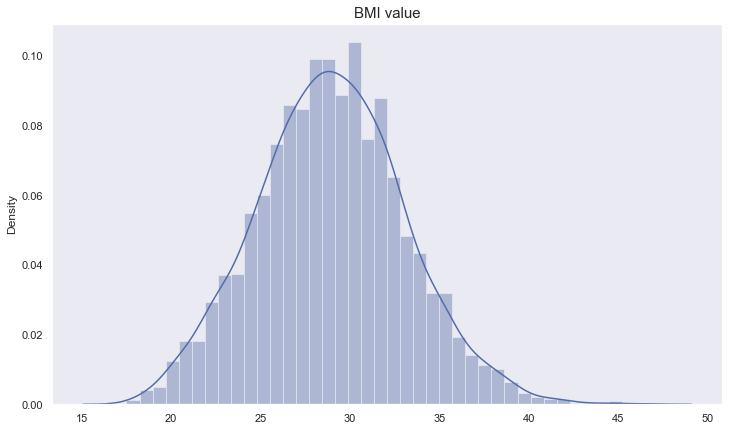

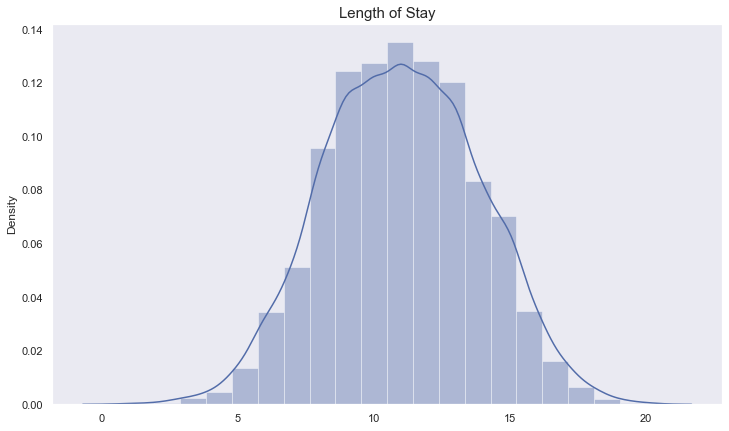

In [25]:
plot_dist(df, 'BMI_value', 'BMI value', bins = None)
plot_dist(df, 'length_of_stay', 'Length of Stay', len(df.length_of_stay.unique()))

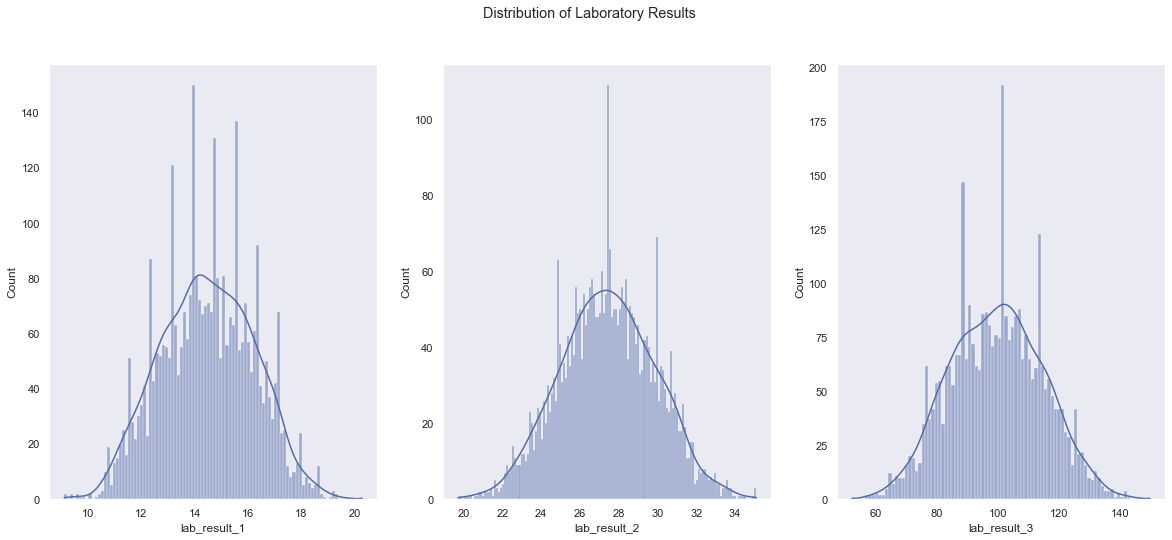

In [26]:
#lab_results
sns.set_theme()
plt.rcParams['axes.grid'] = False
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20,8))

sns.histplot(df['lab_result_1'], color = holmuskblue3, kde=True, ax=ax[0], bins = int(len(df.lab_result_1.unique())))
sns.histplot(df['lab_result_2'], color = holmuskblue3, kde=True,  ax=ax[1], bins = int(len(df.lab_result_2.unique())))
sns.histplot(df['lab_result_3'], color = holmuskblue3, kde=True, ax=ax[2], bins = int(len(df.lab_result_3.unique())))
 
fig.suptitle('Distribution of Laboratory Results');


In [27]:
#describe lab results 
df[['lab_result_1', 'lab_result_2', 'lab_result_3']].describe()

,lab_result_1,lab_result_2,lab_result_3
count,3400.000000,3400.000000,3400.000000
mean,14.469882,27.431529,99.489706
std,1.747323,2.463844,15.254453
min,9.100000,19.700000,52.000000
25%,13.200000,25.800000,88.000000
50%,14.500000,27.400000,100.000000
75%,15.800000,29.100000,110.000000
max,20.300000,35.100000,150.000000


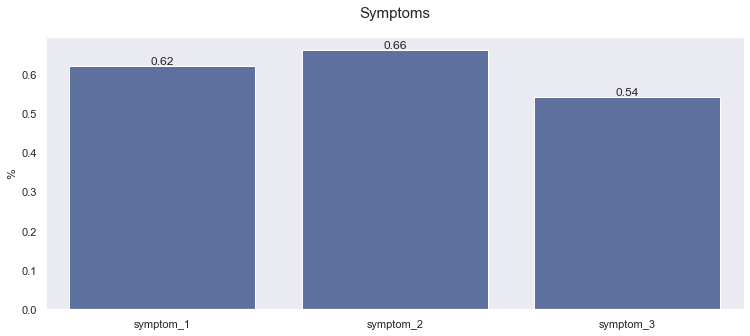

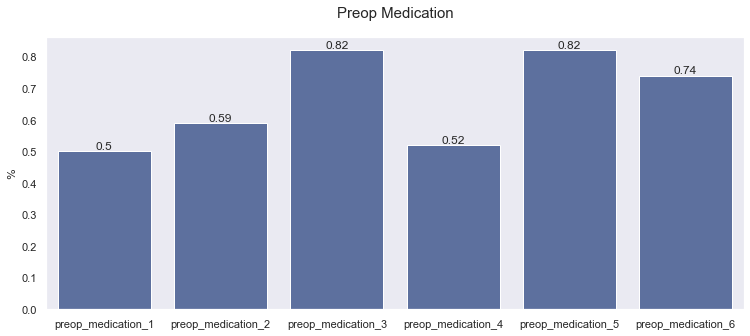

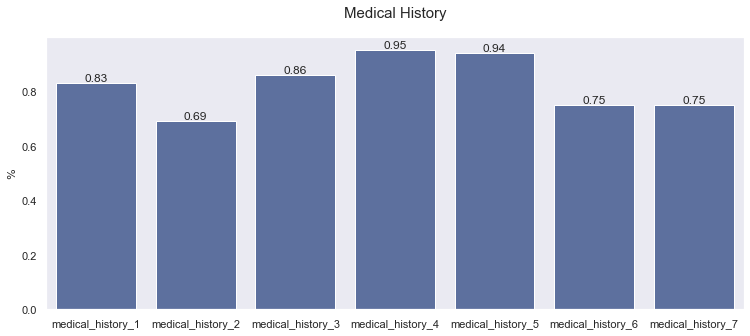

In [28]:
def plot_hist(df, cols, title):
    sns.set_theme()
    plt.figure(figsize = (12.5,5))
    a = df[cols]
    a = a.transpose().apply(pd.Series.value_counts, axis=1)
    a.reset_index(inplace=True)
    a.columns = ['feature', 'pos', 'neg']
    a['perc'] = round(a.pos / (a.pos + a.neg),2)
    a = a[['feature', 'perc']]

    ax = sns.barplot(x="feature", y='perc', data=a, color=colors.to_rgb(holmuskblue3))
    ax.set(ylabel='%', xlabel = None)
    ax.bar_label(ax.containers[0])
    ax.set_title(title, pad = 20, fontsize = 15)
    ax.grid(False)
    plt.show()
    
plot_hist(df, ['symptom_1', 'symptom_2', 'symptom_3'], 'Symptoms')
plot_hist(df, ['preop_medication_1', 'preop_medication_2', 'preop_medication_3', 'preop_medication_4', 'preop_medication_5','preop_medication_6'], 'Preop Medication')
plot_hist(df, ['medical_history_1', 'medical_history_2', 'medical_history_3', 'medical_history_4', 'medical_history_5', 'medical_history_6', 'medical_history_7'], 'Medical History')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


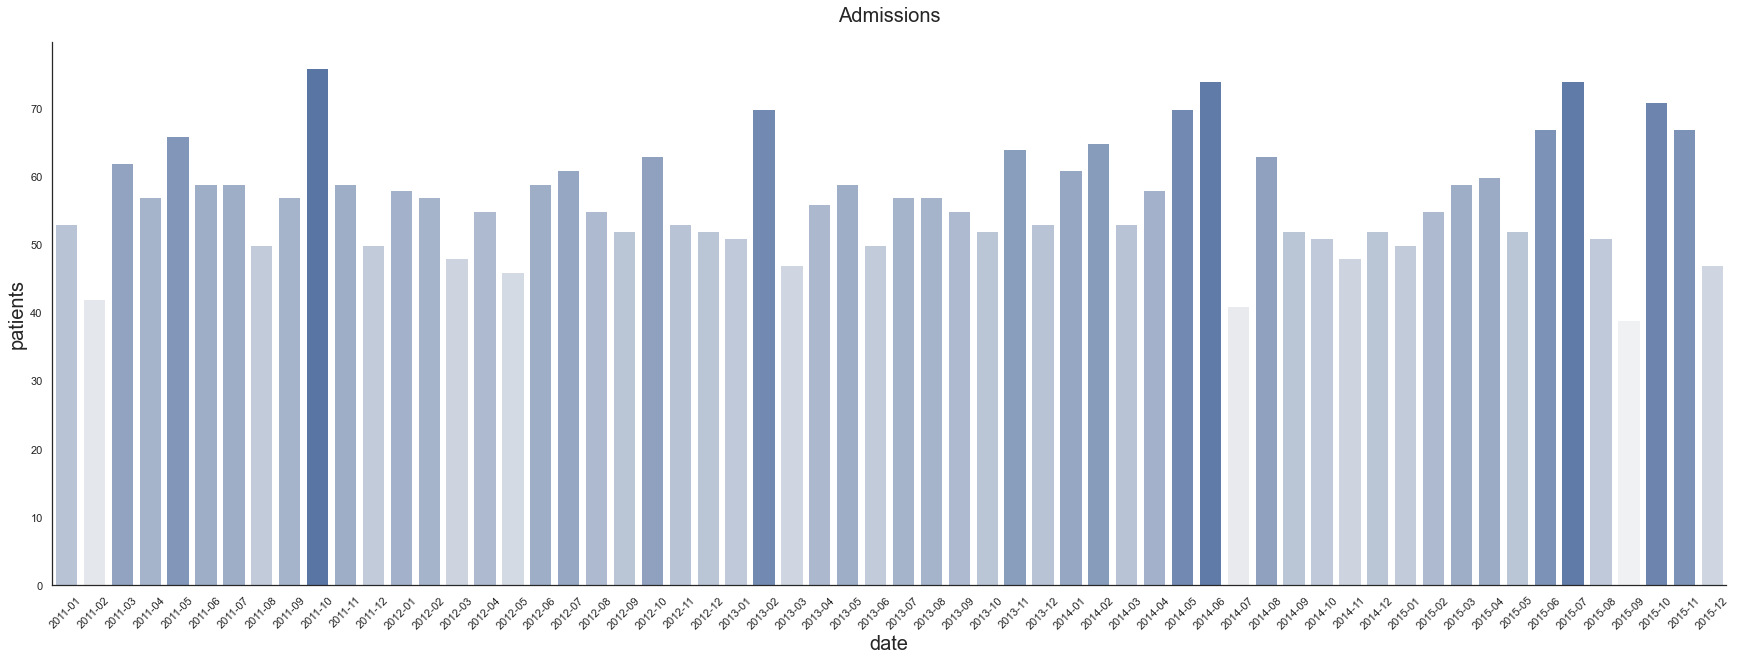

In [29]:
#all admissions 
data = df[['patient_id', 'date_of_admission']]
data.loc[:,'date_of_admission'] = pd.to_datetime(data['date_of_admission']).dt.strftime('%Y-%m')
data = data.groupby(by = 'date_of_admission').agg('count')
data.reset_index(inplace = True)
data.sort_values('date_of_admission', inplace = True)

dims = (30, 10)
sns.set_style("white")

def colors_from_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

plt.figure(figsize = dims)
plt.xticks(rotation = 45)

ax = sns.barplot(data=data, x="date_of_admission", y="patient_id", palette=colors_from_values(data.patient_id, "light:b"))
ax.set_title('Admissions', fontsize = 20, pad = 20)
ax.set_ylabel('patients', fontsize = 20)
ax.set_xlabel('date', fontsize = 20)

sns.despine()




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
FixedFormatter should only be used together with FixedLocator


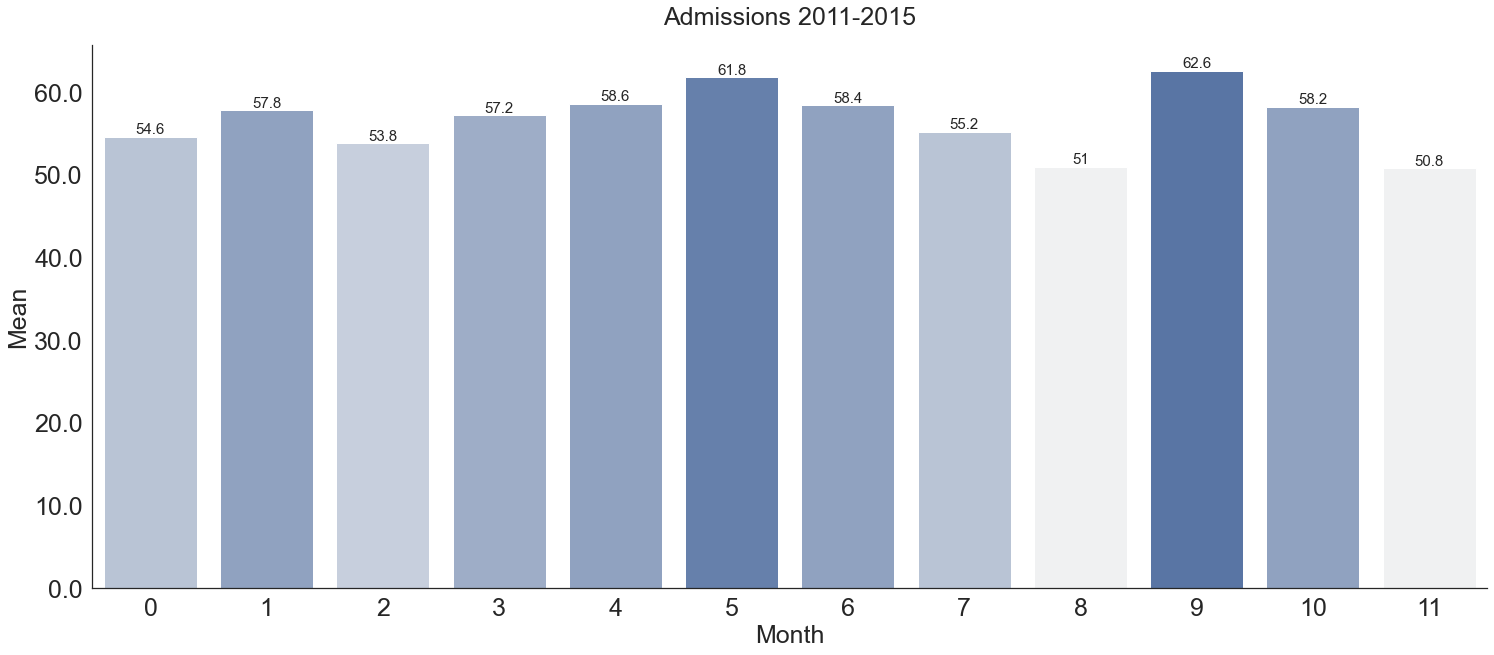

In [30]:
#month level aggreagated admissions
data = df[['patient_id', 'date_of_admission']]
data.loc[:, 'date_of_admission'] = pd.to_datetime(data.date_of_admission.dt.strftime('%Y-%m'))
data.loc[:,'year'] = data.date_of_admission.dt.year
data.loc[:, 'month'] = data.date_of_admission.dt.month

data = data.groupby(['year', 'month']).agg({'patient_id':'count'})
data = data.groupby(['month']).agg({'patient_id':'mean'})
data.rename(columns = {'patient_id':'patients_mean'}, inplace = True)
data.reset_index(inplace=True)

plt.figure(figsize = (25, 10))

ax = sns.barplot(data=data, x="month", y="patients_mean", palette=colors_from_values(data.patients_mean, "light:b"), ci = 'sd')
ax.set_title('Admissions 2011-2015', fontsize = 25, pad = 20)
ax.set_ylabel('Mean', fontsize = 25)
ax.set_xlabel('Month', fontsize = 25)
ax.set_yticklabels(ax.get_yticks(), size = 25)
ax.set_xticklabels(ax.get_xticks(), size = 25)

for container in ax.containers:
    ax.bar_label(container, fontsize = 15)
    
sns.despine()


## Missing Value Analysis 
To decide how to handle the missing values in medical_history_2 and medical_history_5, we conduct a missing value analysis. 

In [31]:
#missing value percentages
missing = pd.DataFrame()
missing['count'] = df.isna().sum()
missing['%'] = round(df.isna().sum().sort_values(ascending=False)/len(df) * 100, 2)
missing

,count,%
patient_id,0,0.00
date_of_birth,0,0.00
gender,0,0.00
race,0,0.00
resident_status,0,0.00
weight,0,0.00
height,0,0.00
BMI_value,0,0.00
BMI_class,0,0.00
age_on_admission,0,0.00


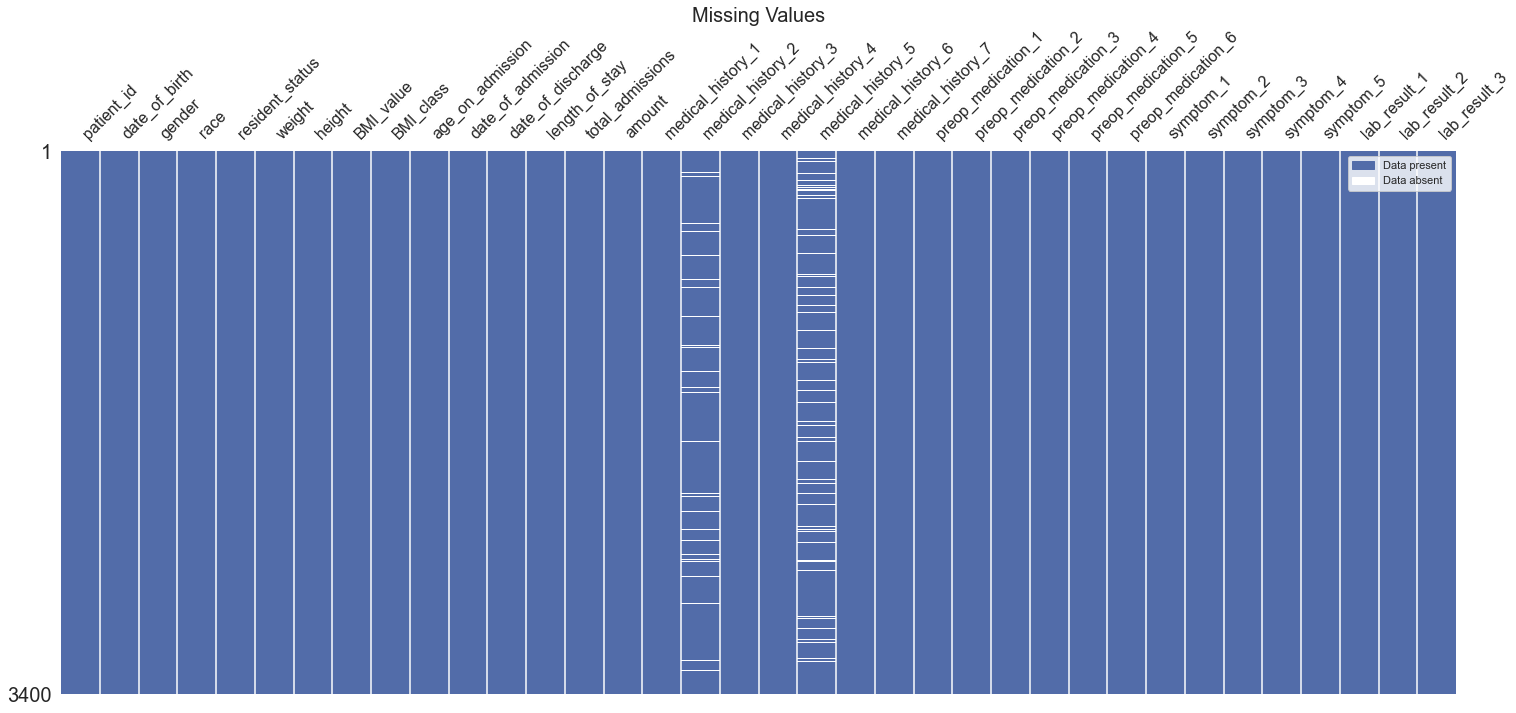

In [32]:
#missing data in the whole data set 
m = msno.matrix(df.sort_values('date_of_birth'), sparkline=False, color = colors.to_rgb(holmuskblue3))
gray = mpatches.Patch(color=holmuskblue3, label='Data present')
white = mpatches.Patch(color='white', label='Data absent ')
plt.legend(handles=[gray, white])
plt.title('Missing Values', fontsize=20)

plt.show()

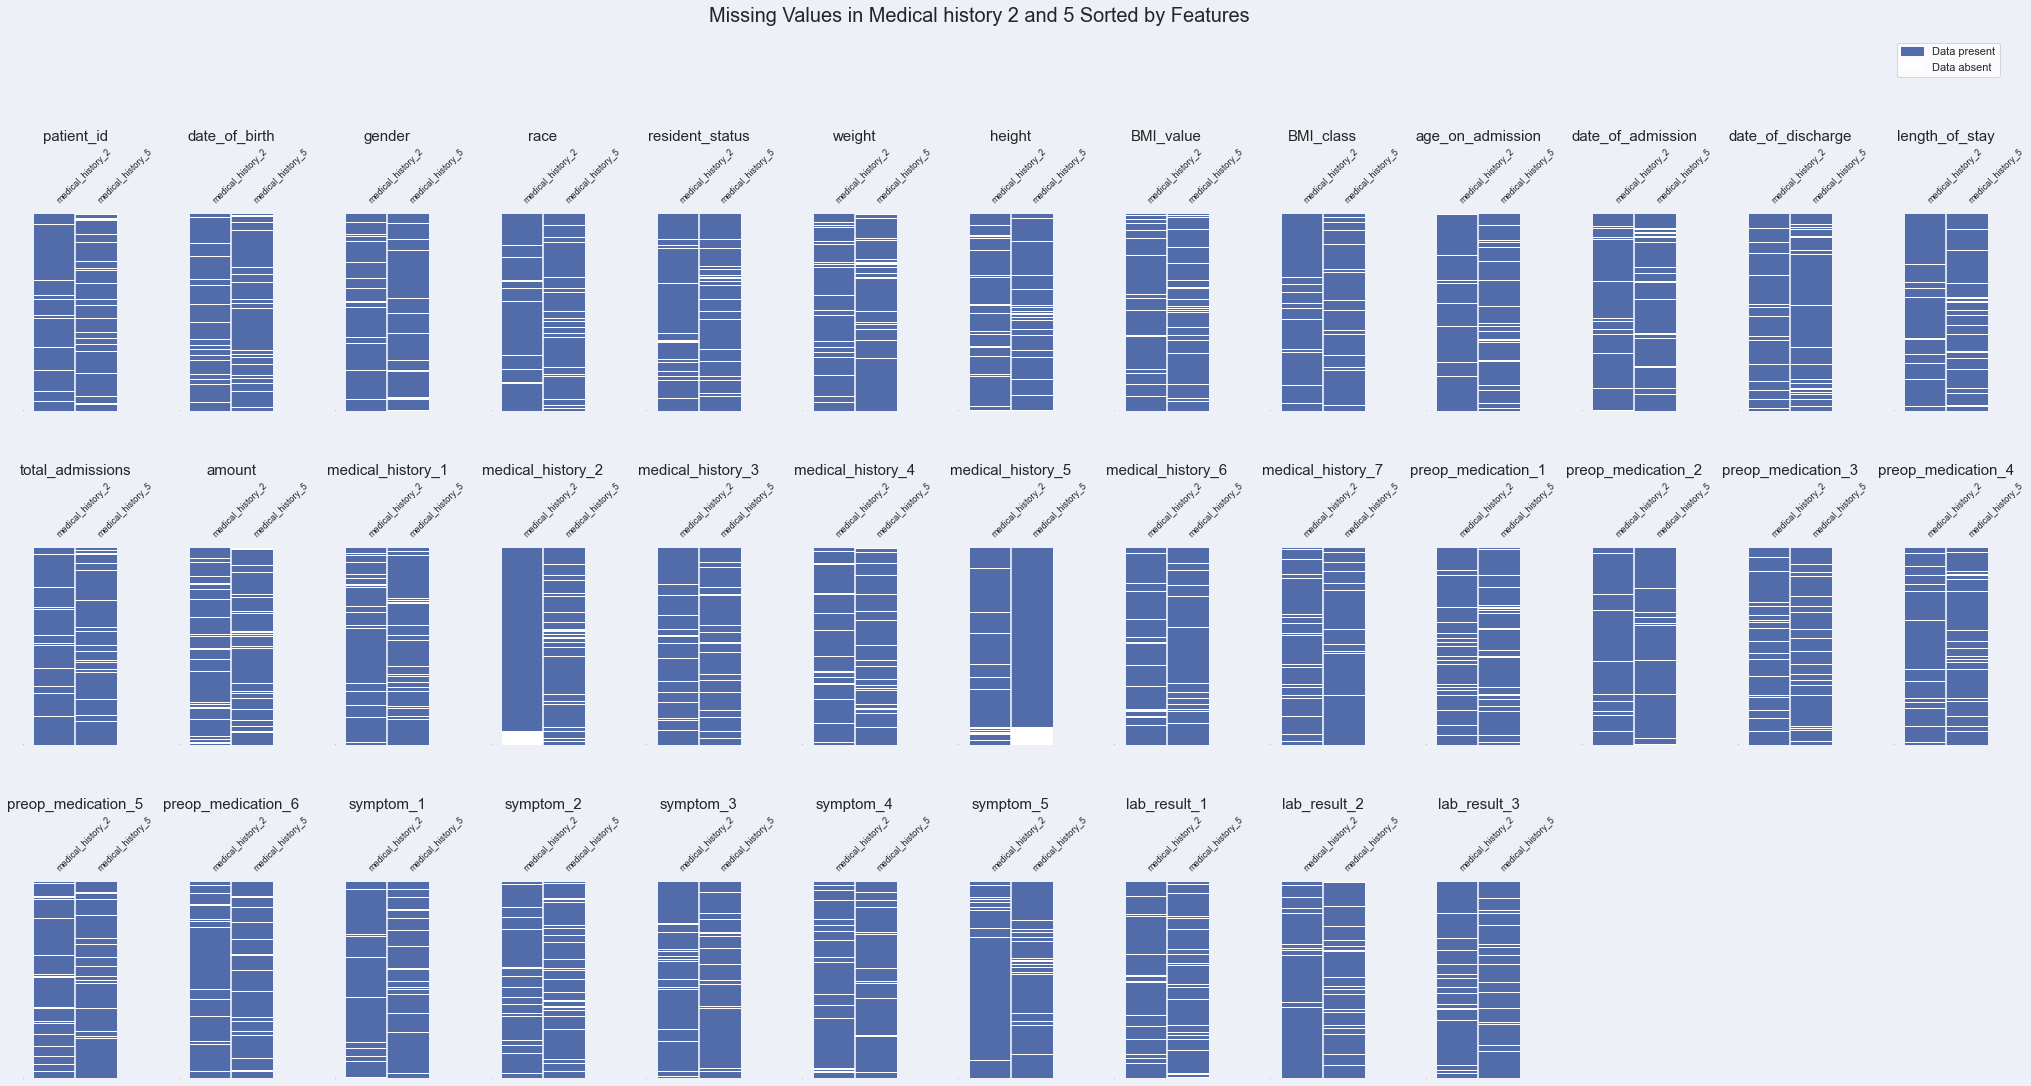

In [33]:
#missing data in medical_history_2 and medical_history_5, data sorted by features
nrows = 3
ncols = 13
fig, axes = plt.subplots(nrows,ncols, figsize=(35,16), facecolor=holmuskbg)
fig.suptitle("Missing Values in Medical history 2 and 5 Sorted by Features", fontsize=20)
plt.subplots_adjust(top = 0.8, bottom=0.05, hspace=0.7, wspace=0.9)


row = 0
col = 0
for column in df.columns[0:(nrows*ncols)]:
    a = df.sort_values(by = column)
    a = a[['medical_history_2', 'medical_history_5']]
    m = msno.matrix(a, sparkline=False, fontsize = 9, labels=True, color=colors.to_rgb(holmuskblue3), ax=axes[row, col])
    m.axes.tick_params(axis='y', labelsize = 0)
    m.axes.set_title(column, fontsize=15)
    
    if col < ncols-1: 
        col = col+1
    else: 
        col = 0
        row = row+1
        
axes[2,10].set_axis_off()
axes[2,11].set_axis_off()
axes[2,12].set_axis_off()


blue = mpatches.Patch(color=colors.to_rgb(holmuskblue3), label='Data present')
white = mpatches.Patch(color='white', label='Data absent ')
plt.legend(handles=[blue, white], loc = (-0.1, 5.1))

plt.show()


The missing values seem to not have connections to each other or to the features. Since missing values seem random and we don't know the data sampling method, meaning of features medical_history_2 and medical_history_5 and we don't know their distribution in population, we decide not to conduct imputations and instead delete the rows with missing data. 

In [34]:
#drop the empty values
df.dropna(inplace = True)

# Relationships of the features 

In [35]:
#dummies
df_dummies = pd.get_dummies(df[df.columns[1:]])
df_dummies.insert(loc = 0, column= 'patient_id', value = df.patient_id)
df_dummies.head()

,patient_id,date_of_birth,weight,height,BMI_value,age_on_admission,date_of_admission,date_of_discharge,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,gender_f,gender_m,race_Chinese,race_Indian,race_Malay,race_Other,resident_status_Foreigner,resident_status_PR,resident_status_Singapore citizen,resident_status_Singaporean,BMI_class_normal,BMI_class_obese,BMI_class_overweight,BMI_class_underweight
0,00225710a878eff524a1d13be817e8e2,1983-01-16,66.9,155.0,27.845994,31,2014-04-10,2014-04-22,12,1,5190.566695,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.4,27.9,96.0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
1,0029d90eb654699c18001c17efb0f129,1943-10-14,89.1,160.0,34.804687,69,2012-11-07,2012-11-20,13,1,22601.497872,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,16.7,26.5,109.0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
2,0040333abd68527ecb53e1db9073f52e,1972-08-26,79.5,172.0,26.872634,40,2013-01-19,2013-01-31,12,1,17447.181635,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.8,25.2,96.0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
3,00473b58e3dc8ae37b3cb34069705083,1976-07-23,81.1,160.0,31.679687,37,2014-02-10,2014-02-15,5,1,15285.883220,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,14.9,28.7,122.0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
4,0078662d1d983dde68ea057c42d5b5cf,1942-10-19,74.7,173.0,24.959070,69,2012-04-28,2012-05-10,12,1,73477.869010,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,14.2,27.2,89.0,0,1,0,0,1,0,1,0,0,0,0,0,1,0


In [36]:
#drop redundant columns: 
df_dummies.drop('gender_f', axis = 1, inplace = True)

Text(0.5, 1.0, 'Correlation Heatmap')

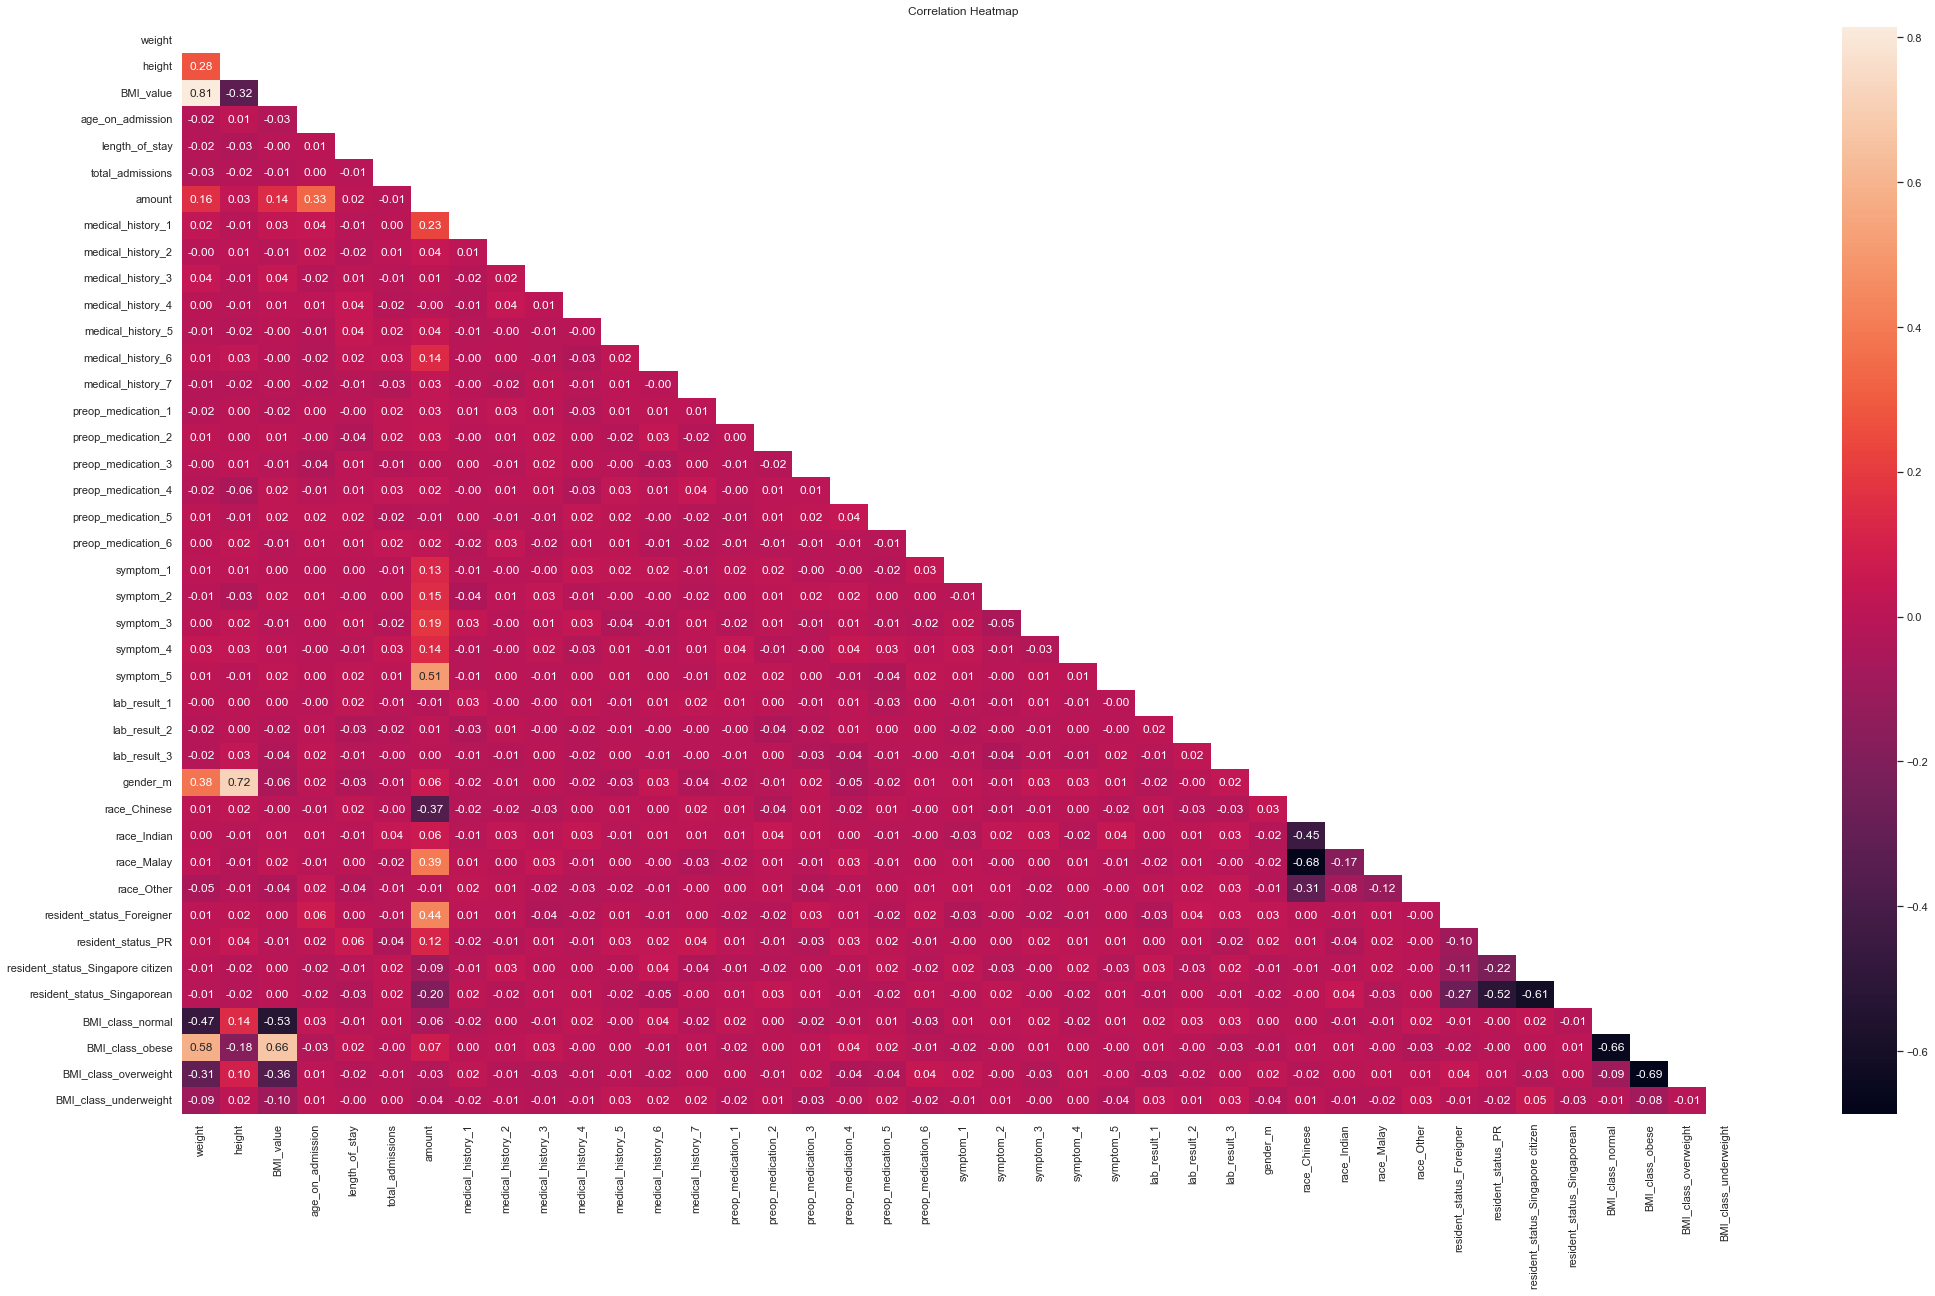

In [37]:
# Pearson correlation matrix and heatmap, all features: 
plt.figure(figsize=(35, 20))
mask = np.triu(np.ones_like(df_dummies.corr(method = 'pearson'), dtype=bool))
heatmap = sns.heatmap(df_dummies.corr(), annot=True, fmt=".2f", mask = mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

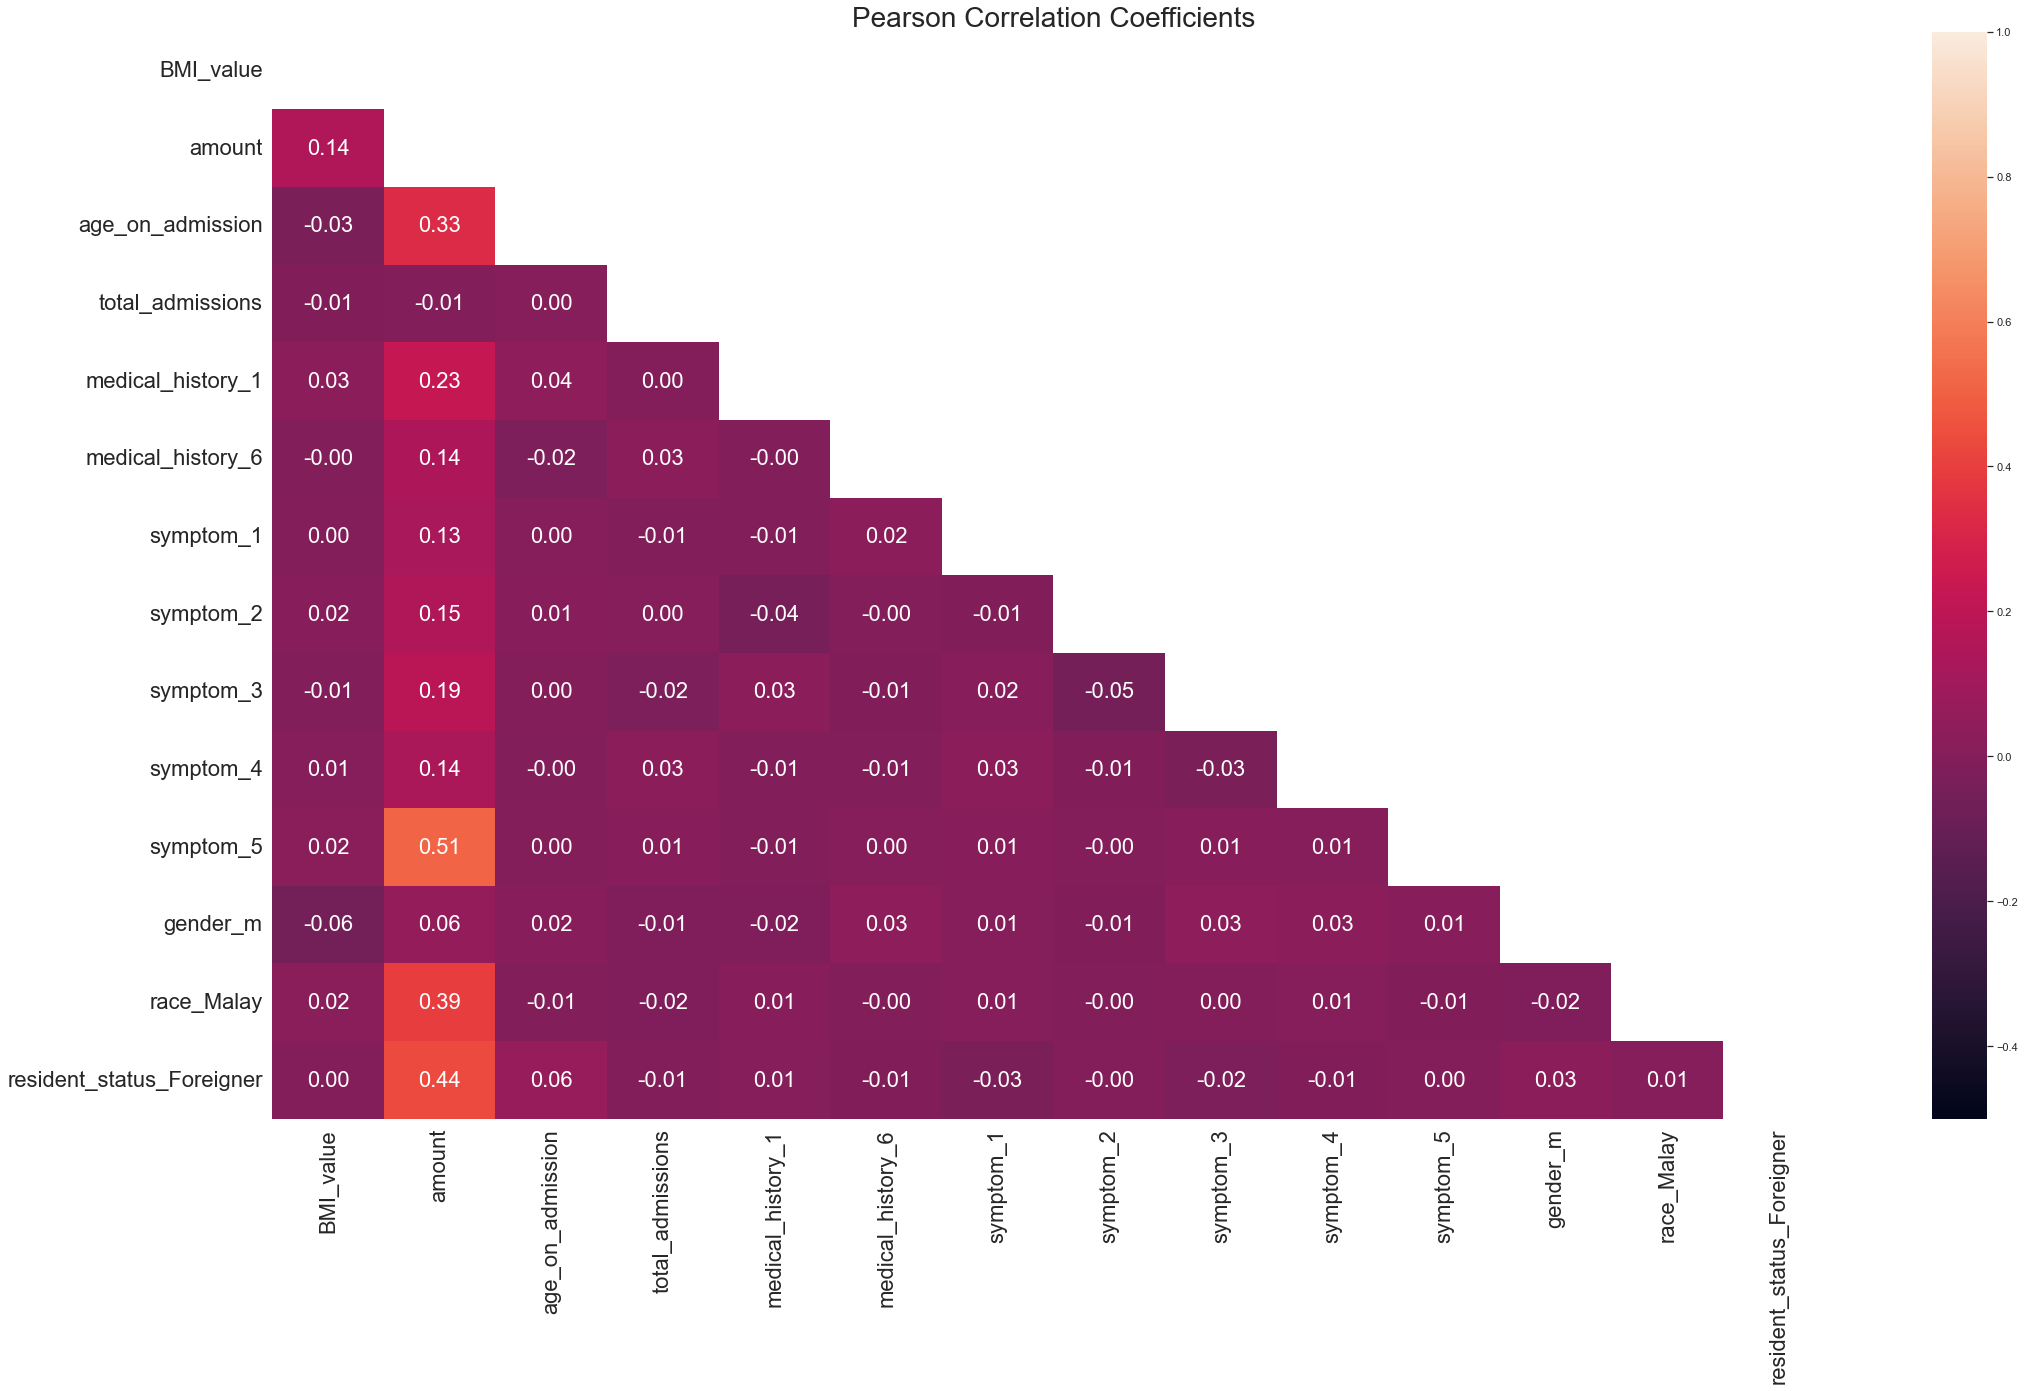

In [38]:
#selecting only some of the features to heatmap
some = df_dummies[['BMI_value', 'amount', 'age_on_admission', 'total_admissions', 'medical_history_1', 'medical_history_6', 'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'gender_m', 'race_Malay', 'resident_status_Foreigner']]

# Pearson correlation matrix and heatmap: 
plt.figure(figsize=(35, 20))
mask = np.triu(np.ones_like(some.corr(), dtype=bool))
heatmap = sns.heatmap(some.corr(method = 'pearson'), annot=True, annot_kws={"size": 22}, fmt=".2f", mask = mask, vmin = -0.5, vmax = 1)
heatmap.set_title('Pearson Correlation Coefficients', fontdict={'fontsize':28}, pad=5)
heatmap.set_yticklabels(heatmap.get_xmajorticklabels(), fontsize = 22)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 22, rotation = 90);


In [39]:
def plot_boxplot(df, x, y, title):
    ax = sns.boxplot(x=x, y=y, data=df, palette = holmuskpalette_diverse)
    ax.yaxis.set_major_formatter(FuncFormatter(monetary_ticks))
    ax.set_ylabel('cost(SGD)')
    ax.set_title(title, pad = 20, fontsize = 15)
    sns.despine()

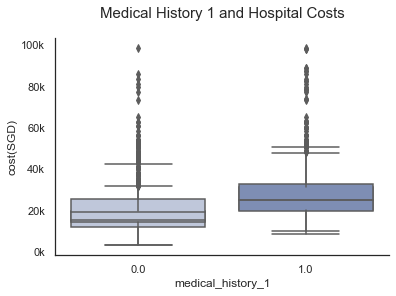

In [40]:
plot_boxplot(df, "symptom_5", "amount", 'Symptom 5 and Hospital Costs')
plot_boxplot(df, "medical_history_1", "amount", 'Medical History 1 and Hospital Costs')

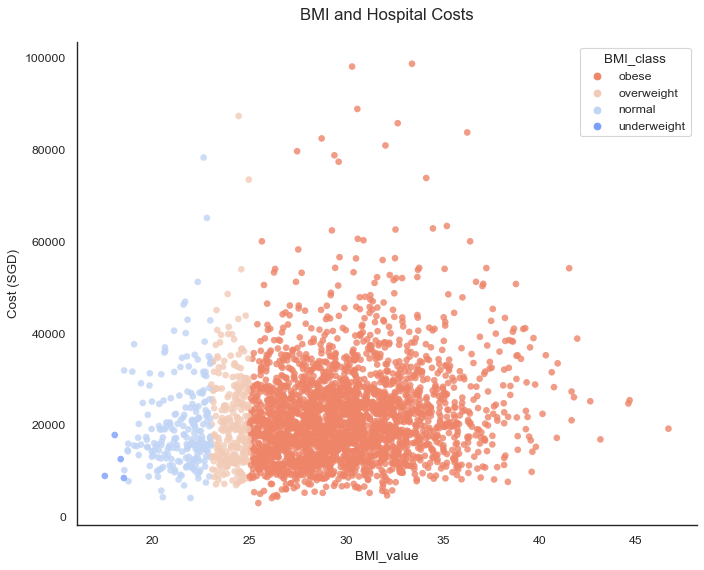

In [41]:
#BMI_value and amount 
plt.figure(figsize=(10, 8), dpi = 80)
ax = sns.scatterplot(data=df, x="BMI_value", y="amount", hue = 'BMI_class', palette='coolwarm_r', alpha = 0.8, linewidth=0)
ax.set_title('BMI and Hospital Costs', pad = 20, fontsize = 15)
ax.set_ylabel('Cost (SGD)')
sns.despine()

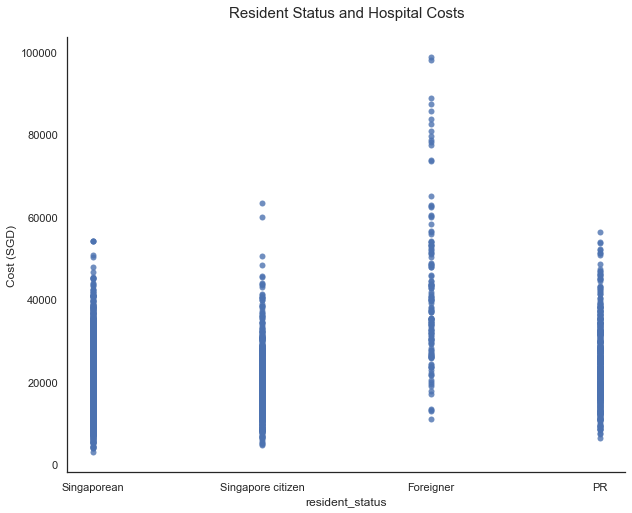

In [42]:
#resident status and hospital costs
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=df, x="resident_status", y="amount", palette='coolwarm_r', alpha = 0.8, linewidth=0)
ax.set_title('Resident Status and Hospital Costs', pad = 20, fontsize = 15)
ax.set_ylabel('Cost (SGD)')
sns.despine()

Based on the plot above and formal definition 'citizen', it makes sense to put Singaporean, Singapore citizen and PR into same category. Let's define feature 'Singaporean': 

In [43]:
df['resident_status'] = df['resident_status'].replace(['Singaporean', 'Singapore citizen', 'PR'], 'Singaporean')

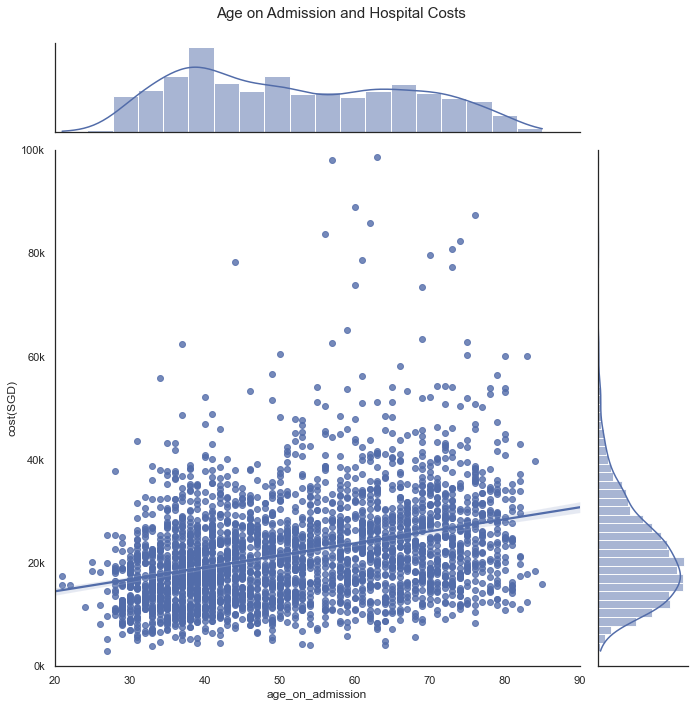

In [44]:
#Age on admission and amount 
sns.set_style("white", {'axes.grid' : False})

#plt.subplots(figsize=(20,20))    
g = sns.jointplot(x="age_on_admission", y="amount", data=df,
                  kind="reg", truncate=False,
                  xlim=(20, 90), ylim=(0, 100000), height = 10, color = holmuskblue3)

g.fig.suptitle('Age on Admission and Hospital Costs', fontsize = 15)
g.fig.subplots_adjust(top=0.93) 
g.ax_joint.yaxis.set_major_formatter(FuncFormatter(monetary_ticks))
g.set_axis_labels("age_on_admission", "cost(SGD)", fontsize=12)

sns.despine()


## Predictive Modelling: Frequent Hospital Admissions
What features on the first admission predict subsequent hospital admissions during the year of the first admission? We define frequent patient as a patient that is admitted again in a year after the first admission. Since the last record of the data is 28.12.2015, patients that are admitted after 28.12.2014 are excluded. Foreigners are excluded since their primary healthcare might not be in Singapore. 

In [45]:
df.sort_values('date_of_admission', inplace = True) 

In [46]:
#create frequent patient feature
df['freq'] = 0
df['due_date'] = 0

freq_patients = []

for i, row in df.iterrows(): 
    patient = row.patient_id
    admission_date = row.date_of_admission
    due_date = row.date_of_admission + relativedelta(years=1)
    df['due_date'][i] = due_date
    exclude_date = datetime.strptime('2014-12-28', '%Y-%m-%d')
    subsequents = df[((df.patient_id == patient) & (df.date_of_admission<due_date) & (df.date_of_admission > admission_date))]
    #admissions after the first admission are excluded
    if patient in freq_patients: 
        df['freq'][i] = -1
    #frequent patient
    elif ((admission_date < due_date) & len(subsequents)>0):
        df['freq'][i] = 1
        freq_patients.append(patient)
    #excluded
    if admission_date > exclude_date: 
        df['freq'][i] = -1

df.drop('due_date', axis = 1, inplace = True)
    


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
data = df
data = data[data.freq >-1]
data = data[data.resident_status != 'Foreigner']

In [48]:
frequent_patients = data[data['freq']==1]
onetime_patients = data[data['freq']==0]
print('Number of patients:', len(data))
print('Number of patients that have multiple admissions: ', len(frequent_patients))
print('Number of patients that have single admission: ', len(onetime_patients))

Number of patients: 2112
Number of patients that have multiple admissions:  96
Number of patients that have single admission:  2016


In [49]:
frequent_patients.describe()

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,freq
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,79.542708,165.677083,29.081241,50.468750,11.083333,2.145833,20836.286361,0.156250,0.302083,0.156250,0.062500,0.041667,0.270833,0.250000,0.562500,0.604167,0.802083,0.458333,0.854167,0.697917,0.625000,0.59375,0.604167,0.750000,0.572917,14.396875,27.323958,99.239583,1.0
std,10.580526,7.085188,4.238341,14.265861,2.886144,0.383314,8233.251788,0.364998,0.461571,0.364998,0.243332,0.200875,0.446723,0.435286,0.498682,0.491596,0.400520,0.500876,0.354792,0.461571,0.486664,0.49371,0.491596,0.435286,0.497251,1.693607,2.601811,14.068812,0.0
min,55.200000,151.000000,20.262593,29.000000,4.000000,2.000000,4949.806331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,11.100000,20.100000,68.000000,1.0
25%,71.375000,161.000000,26.047675,38.000000,9.000000,2.000000,14963.670831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.750000,0.000000,13.100000,25.800000,90.000000,1.0
50%,79.300000,166.000000,29.456112,49.000000,11.000000,2.000000,20473.108810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,14.100000,27.200000,99.000000,1.0
75%,86.825000,171.000000,31.497526,64.250000,13.000000,2.000000,25137.077684,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,15.525000,29.225000,107.250000,1.0
max,107.800000,179.000000,41.540062,77.000000,18.000000,4.000000,54142.013597,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,18.100000,34.000000,133.000000,1.0


In [50]:
onetime_patients.describe()

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,freq
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.0
mean,78.810962,165.062996,28.989888,51.373016,11.051091,1.167659,20931.042481,0.169643,0.313988,0.142361,0.052579,0.065476,0.257937,0.253968,0.501488,0.594246,0.821429,0.513393,0.821429,0.750992,0.627976,0.665675,0.549107,0.728175,0.531746,14.459921,27.406895,99.581349,0.0
std,10.876831,7.066329,4.106212,14.710734,2.863628,0.403048,8634.248790,0.375412,0.464227,0.349507,0.223248,0.247426,0.437607,0.435388,0.500122,0.491159,0.383088,0.499945,0.383088,0.432546,0.483465,0.471871,0.497706,0.445011,0.499115,1.754167,2.511541,15.285872,0.0
min,48.000000,151.000000,18.022639,21.000000,1.000000,1.000000,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,57.000000,0.0
25%,71.400000,160.000000,26.269537,39.000000,9.000000,1.000000,14563.051690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.200000,25.700000,88.000000,0.0
50%,79.000000,165.000000,28.841370,49.000000,11.000000,1.000000,19698.759614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,27.400000,100.000000,0.0
75%,86.200000,171.000000,31.727719,64.000000,13.000000,1.000000,25851.131541,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.700000,29.200000,111.000000,0.0
max,115.200000,186.000000,44.667126,83.000000,20.000000,4.000000,60010.177658,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.300000,35.100000,142.000000,0.0


In [51]:
o = pd.get_dummies(onetime_patients[['gender']])
f = pd.get_dummies(frequent_patients[['gender']])

#t-tests to see if the groups differ 
from scipy.stats import ttest_ind

cat1 = onetime_patients.amount
cat2 = frequent_patients.amount

print(ttest_ind(cat1, cat2))

Ttest_indResult(statistic=0.10527020806663427, pvalue=0.9161714080381067)


In [52]:
#save processed data
df.to_csv('preprocessed_data/data_preprocessed.csv', index=False)

There was no statistically significant differences between the groups, in any of the features.

### Logistic Regression Model

Building a simple logistic regression model to predict label (frequent_patient or not). We choose parameters based on correlation coefficients visualized in the heatmap previously. 


In [53]:
#drop some features and dummy code categorical variables
data = data.drop(['patient_id', 'date_of_admission', 'date_of_discharge', 'date_of_birth', 'total_admissions', 'weight', 'height', 'BMI_class', 'lab_result_1', 'lab_result_2', 'lab_result_3', 'preop_medication_1', 'preop_medication_2', 'preop_medication_3'], axis = 1)
data = pd.get_dummies(data, drop_first = True)
data.head()

,BMI_value,age_on_admission,length_of_stay,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,freq,gender_m,race_Indian,race_Malay,race_Other
1281,30.625000,32,10,23303.000924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0,1,0
397,27.506655,34,10,15405.418665,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,1,1,0,0
1570,29.958678,74,16,17153.905421,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,1,0,0,0
2961,27.873961,43,12,27994.878530,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
2644,31.577562,43,11,16813.123088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0,1,0,0


In [54]:
#train and test data 
x = data.drop('freq', axis = 1)
y = data['freq']

In [55]:
#train data (90% of the data) and test data (10% of the data)
x = data.drop('freq', axis = 1)
y = data['freq']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 25, shuffle = True)

#let's further separate validation data set (10 % from the train_data): 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 25, shuffle = False)

print(f"training examples: {x_train.shape[0]}")
print(f"testing examples: {x_test.shape[0]}")
print(f'validation examples: {x_val.shape[0]}')

training examples: 1710
testing examples: 212
validation examples: 190


In [56]:
#measure training data unbalance and balance with SMOTE
n_freq = len(data[data.freq == 1])
print('Frequent patients in the data before balancing:', round(n_freq/len(data),4))

oversample = SMOTE()
x_res, y_res = oversample.fit_resample(x, y)

n_freq = len(y_res[y_res == 1])
print('Frequent patients in the data after balancing:', round(n_freq/len(y_res),4))

Frequent patients in the data before balancing: 0.0455
Frequent patients in the data after balancing: 0.5


In [57]:
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size = 0.2, random_state = 25, shuffle = True)
print(f"training examples: {x_train.shape[0]}")
print(f"testing examples: {x_test.shape[0]}")

training examples: 3225
testing examples: 807


In [58]:
#normalize 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform( x_train )
x_test_scaled = scaler.transform( x_test )

x_train = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)

In [59]:
#fit model 
log_model = LogisticRegression(n_jobs = -1, multi_class='auto', penalty = 'l2')
log_model = log_model.fit(x_train, y_train)

In [60]:
#predictions
y_pred = log_model.predict(scaler.transform(x_val))

X does not have valid feature names, but LogisticRegression was fitted with feature names


Text(0.5, 257.44, 'Predicted label')

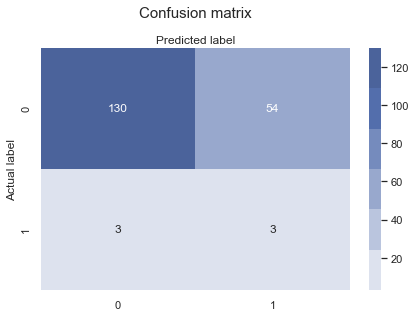

In [61]:
#Evaluation the performance: confusion matrix 

cnf_matrix = confusion_matrix(y_val, y_pred)

class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix, annot=True, cmap = holmuskpalette_light, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, fontsize = 15)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


As we can see, model performance could be better. Model performance could be improved with larger data and tuning the parameters further.  

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


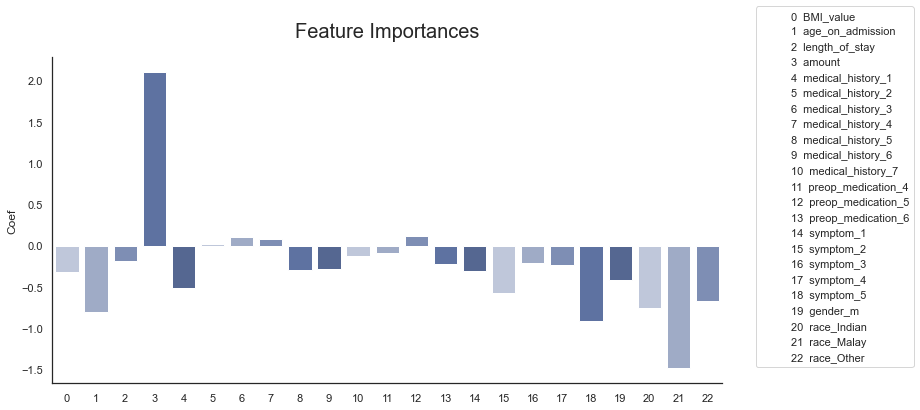

In [62]:
#Feature Importances
importance = log_model.coef_[0]
fig, ax = plt.subplots(figsize = (12, 6))

labels = []
for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v), x_train.columns[i])
    labels.append(str(i) + '  ' + x_train.columns[i])
    
ax = sns.barplot([x for x in range(len(importance))], importance, palette=holmuskpalette_light[1:])
ax.set(ylabel='Coef', xlabel = None)
ax.set_title('Feature Importances', fontsize = 20, pad = 20)
ax.grid(False)

plt.legend(loc=(1.05, 0.05), labels=labels, markerscale = 0)
leg = plt.gca().get_legend()
for item in leg.legendHandles:
    item.set_visible(False)
    
sns.despine()

## Predictive Modelling: Hospital Costs

Which features explain higher hospital costs? 


### Random Forest Regression Model

Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression.  
Random Forest Regression uses Bootstrap Aggregation (Bagging): Each decision tree runs independently and at the end the outputs are aggregated by average. 

We chose Random Model Regressor to predict hospital costs (feature 'amount'), since it is often good for non-linear data to predict continuous labels. It is also not easy to overfit due to subset and feature randomization.

In [63]:
#drop non-useful and redundant features and dummy code categorical data
data = df
data.drop(['patient_id', 'date_of_admission', 'date_of_discharge', 'date_of_birth', 'weight', 'height', 'BMI_class'], axis = 1, inplace = True)
data = pd.get_dummies(data, drop_first = True)
data.head()

,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,freq,gender_m,race_Indian,race_Malay,race_Other,resident_status_Singaporean
1281,30.625000,32,10,1,23303.000924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,13.8,22.6,89.0,0,0,0,1,0,1
397,27.506655,34,10,2,15405.418665,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,13.2,30.9,123.0,0,1,1,0,0,1
1570,29.958678,74,16,1,17153.905421,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,12.1,23.6,109.0,0,1,0,0,0,1
2961,27.873961,43,12,1,27994.878530,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.3,28.4,76.0,0,0,0,0,0,1
2644,31.577562,43,11,2,16813.123088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,11.2,26.2,100.0,0,0,1,0,0,1


In [64]:
#train data (90% of the data) and val data (20% of the data)
x = data.drop('amount', axis = 1)
y = data['amount']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 25, shuffle = True)

print(f"training examples: {x_train.shape[0]}")
print(f"testing examples: {x_val.shape[0]}")

training examples: 2318
testing examples: 580


In [65]:
#fit the scaler 
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [66]:
#pipeline and model fitting
pipe = make_pipeline(scaler, SelectKBest(mutual_info_regression), RandomForestRegressor(random_state = 25))
pipe.get_params().keys()

params = {
    'selectkbest__k': [20], #[15, 20, 25], #20
    'randomforestregressor__criterion': ['squared_error'], #['squared_error', 'absolute_error'],#['squared_error', 
    'randomforestregressor__max_depth' : [15], #[10, 12, 15],#[15]
    'randomforestregressor__max_features': ['auto'], #['auto', 'sqrt', 'log2'],#['auto']
    'randomforestregressor__n_estimators' : [1100] #[900, 1100, 1200]  #1200
}

In [67]:
gs = GridSearchCV(pipe, params, n_jobs=-1, cv=7, return_train_score=True, refit = True)
gs.fit(x_train, y_train)
gs.best_params_

{'randomforestregressor__criterion': 'squared_error',
 'randomforestregressor__max_depth': 15,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 1100,
 'selectkbest__k': 20}

In [68]:
#performance metrics
def evaluate(model, x_vali, y_vali, y_preds):
    print('Model Performance:')
    print('Root Mean Squared Error (RMSE): {:0.4f}'.format(np.sqrt(mean_squared_error(y_vali, y_preds))))
    print('Mean Absolute Error (MAE): {:0.4f} (deg)'.format(mean_absolute_error(y_vali, y_preds)))
    print('Explained variance score: {:0.4f}'.format(explained_variance_score(y_vali, y_preds)))


In [69]:
# MAE of predicting always mean of 'amount'
baseline_preds = data.amount.mean()
baseline_errors = abs(baseline_preds - y)
print('Mean Average error (MAE) of predicting always mean: {:0.4f}'.format(baseline_errors.mean()))

Mean Average error (MAE) of predicting always mean: 7602.0338


In [70]:
#baseline model (RandomForestRegressor with default parameter values)
base_model = RandomForestRegressor(random_state = 30)
base_model = base_model.fit(x_train, y_train)
base_y_pred = base_model.predict(x_val)
evaluate(base_model, x_val, y_val, base_y_pred)

Model Performance:
Root Mean Squared Error (RMSE): 3387.8401
Mean Absolute Error (MAE): 2371.7308 (deg)
Explained variance score: 0.8893


In [71]:
#evaluate the tuned model
y_pred = gs.predict(x_val)
grid_accuracy = evaluate(gs, x_val, y_val, y_pred);

Model Performance:
Root Mean Squared Error (RMSE): 3162.1074
Mean Absolute Error (MAE): 2177.8125 (deg)
Explained variance score: 0.9035


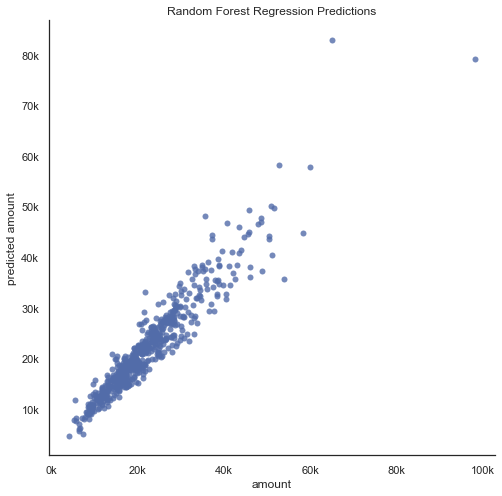

In [72]:
#plotting the predictions vs correct values: 
y_pred = gs.predict(x_val)
plt.figure(figsize=(8, 8))
g = sns.scatterplot(x=y_val, y=y_pred, color = holmuskblue3, alpha = 0.8, linewidth=0)
g.set_title('Random Forest Regression Predictions')
g.set_xlabel('amount')
g.set_ylabel('predicted amount')

g.xaxis.set_major_formatter(FuncFormatter(monetary_ticks))
g.yaxis.set_major_formatter(FuncFormatter(monetary_ticks))

sns.despine()
plt.show() 

#### Feature Importances 

In [74]:
#chosen features
chosen_feat_nos = gs.best_estimator_.named_steps['selectkbest'].get_support(indices = True)
chosen_feats = x_train.columns[chosen_feat_nos].to_list()

feature_importances = gs.best_estimator_._final_estimator.feature_importances_
print(feature_importances)
print(chosen_feats)

[0.04306265 0.12779415 0.0139594  0.04542612 0.00200359 0.02342054
 0.00431079 0.00346487 0.00240732 0.00216633 0.01075717 0.01967777
 0.02515958 0.01560551 0.25619417 0.00520683 0.01436133 0.17984668
 0.00191489 0.20326033]
['BMI_value', 'age_on_admission', 'length_of_stay', 'medical_history_1', 'medical_history_4', 'medical_history_6', 'medical_history_7', 'preop_medication_2', 'preop_medication_3', 'preop_medication_5', 'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'gender_m', 'race_Indian', 'race_Malay', 'race_Other', 'resident_status_Singaporean']


In [77]:
feat_imp['no'] = chosen_feat_nos
chosen_feat_importances = gs.best_estimator_.named_steps['selectkbest'].scores_
chosen_feat_importances = chosen_feat_importances[chosen_feat_nos]
chosen_feat_importances

array([0.00601344, 0.06591628, 0.00976681, 0.02918435, 0.00189267,
       0.01373799, 0.00603083, 0.00950745, 0.00447543, 0.01151215,
       0.01585512, 0.00847327, 0.02912077, 0.01042644, 0.21438834,
       0.00917737, 0.00310138, 0.07646301, 0.        , 0.06172876])

In [78]:
feat_imp = pd.DataFrame()
feat_imp['feature'] = chosen_feats
feat_imp['importance'] = chosen_feat_importances
feat_imp.sort_values('importance', ascending=False)

,feature,importance
14,symptom_5,0.214388
17,race_Malay,0.076463
1,age_on_admission,0.065916
19,resident_status_Singaporean,0.061729
3,medical_history_1,0.029184
12,symptom_3,0.029121
10,symptom_1,0.015855
5,medical_history_6,0.013738
9,preop_medication_5,0.011512
13,symptom_4,0.010426


In [ ]:
g = shap.TreeExplainer(gs.best_estimator_._final_estimator)
shap_values = g.shap_values(x_train)
shap.summary_plot(shap_values, x_train)
